# Time series analysis of Google Trends for "Fourier Transform"

In [ ]:
#%pip install pytrends

In [1]:
#from pytrends.request import TrendReq
import pandas as pd

## Get Google trends data

In [2]:
#pytrends = TrendReq(hl='en-US', tz=360)

In [3]:
#keywords = ['Fourier Transform']
#pytrends.build_payload(keywords, cat=0, timeframe='all', geo='', gprop='')


Note the [maintainer stepped down](https://github.com/GeneralMills/pytrends/issues/636) and the repo is archived. They raise serious concerns about data quality but suggest trendspy as an alternative. Also I keep getting [error 429](https://stackoverflow.com/questions/50571317/pytrends-the-request-failed-google-returned-a-response-with-code-429)

In [4]:
trends_df=pd.read_csv('multiTimeline.csv',skiprows=2,parse_dates=[0]).set_index('Month')#pytrends.interest_over_time()


In [5]:
trends_df.dtypes

Fourier Transform: (Worldwide)    int64
dtype: object

<Axes: xlabel='Month'>

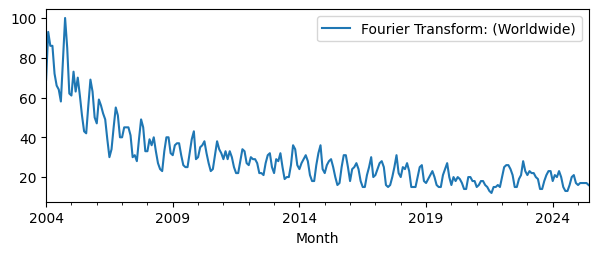

In [6]:
trends_df.plot(figsize=[7,2.5])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

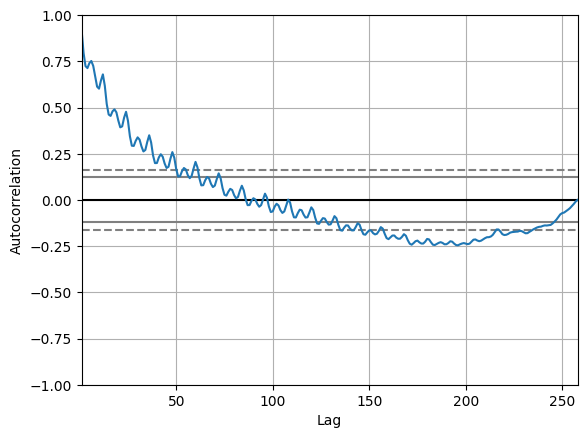

In [7]:
pd.plotting.autocorrelation_plot(trends_df)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

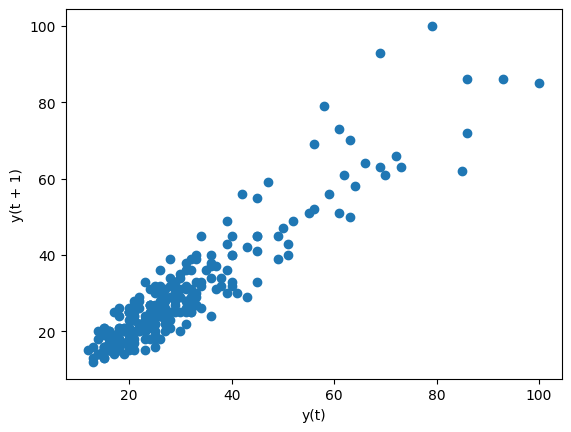

In [8]:
pd.plotting.lag_plot(trends_df,lag=1)

In [9]:
(trends_df
 .assign(Fourier_Transform_shifted_1m=trends_df
         .shift(periods=1)
        )
 .corr()
 .loc['Fourier_Transform_shifted_1m','Fourier Transform: (Worldwide)'] 
)

np.float64(0.9293125693134031)

In [10]:
trends_df['Fourier Transform: (Worldwide)'].autocorr(lag=1)

np.float64(0.9293125693134024)

Periodicity barely stands out in autocorrelation plot against decaying trend. A lag of 1 is the classic use of the lag plot as a test for randomness, as described in the NIST Engineering statistics handbook. In this case the data is definitely not random.

## Diff to remove slow decay, keep periodicity

In [11]:
def non_partial_diff(df):
    return (df
            .diff()
            .rename(columns={"Fourier Transform: (Worldwide)":"Fourier Transform diff"})
            .dropna()
           )

<Axes: xlabel='Month'>

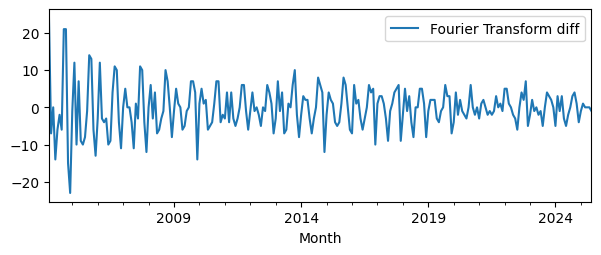

In [12]:
trends_df.pipe(non_partial_diff).plot(figsize=[7,2.5])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

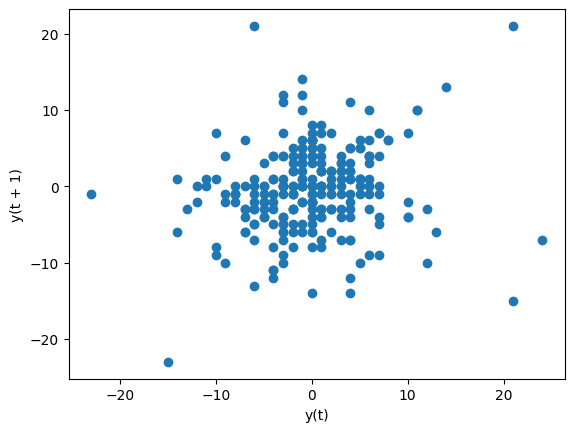

In [13]:
pd.plotting.lag_plot(trends_df.pipe(non_partial_diff),lag=1)

In [14]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform_diff_shift_1m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=1)
        )
 .corr()
 .loc['Fourier_Transform_diff_shift_1m','Fourier Transform diff']

)

np.float64(0.16995405644243025)

In [15]:
trends_df.pipe(non_partial_diff)['Fourier Transform diff'].autocorr(lag=1)

np.float64(0.16995405644243017)

This time the lag 1 plot does show randomness.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

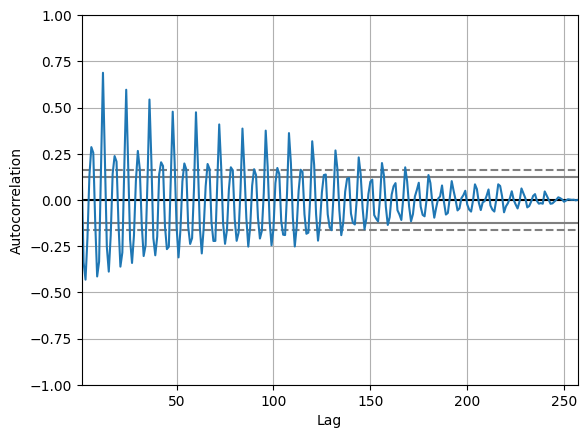

In [16]:
pd.plotting.autocorrelation_plot(trends_df.pipe(non_partial_diff))

In [27]:
(trends_df
 .pipe(non_partial_diff)
 .rename(columns={'Fourier Transform diff':'diff'})
 .agg({'diff':[lambda x:x.autocorr(1),lambda x:x.autocorr(2), lambda x:x.autocorr(3),lambda x:x.autocorr(4),lambda x:x.autocorr(5),lambda x:x.autocorr(6),
              lambda x:x.autocorr(7),lambda x:x.autocorr(8), lambda x:x.autocorr(9),lambda x:x.autocorr(10),lambda x:x.autocorr(11),lambda x:x.autocorr(12)]})
)#.plot()

,diff
<lambda>,0.169954
<lambda>,-0.350834
<lambda>,-0.448156
<lambda>,-0.214893
<lambda>,0.137381
<lambda>,0.301124
<lambda>,0.269454
<lambda>,-0.132719
<lambda>,-0.465998
<lambda>,-0.382056


Monthly data. High peaks: 12, 24, 36, 48... Smaller peaks half way through. 

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

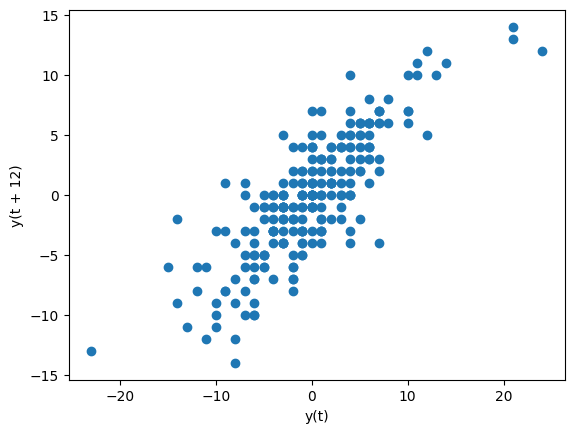

In [28]:
pd.plotting.lag_plot(trends_df.pipe(non_partial_diff),lag=12)

In [29]:
trends_df.pipe(non_partial_diff)['Fourier Transform diff'].autocorr(lag=12)

np.float64(0.8195626269703368)

In [30]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform_diff_shift_12m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=12)
        )
 .corr()
 .loc['Fourier_Transform_diff_shift_12m','Fourier Transform diff']
)

np.float64(0.8195626269703371)

The lag plots for 12 and 6 months lag further confirm the relationship.

<Axes: xlabel='y(t)', ylabel='y(t + 6)'>

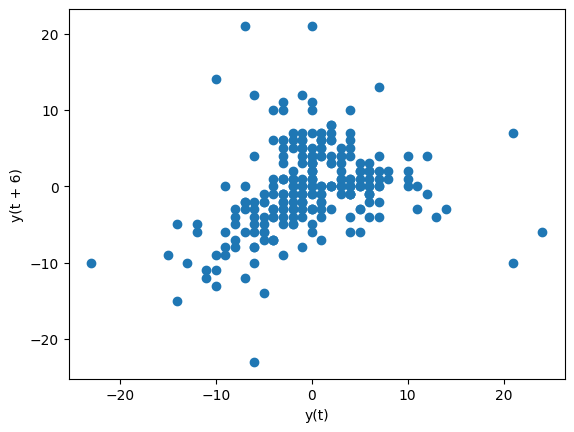

In [31]:
pd.plotting.lag_plot(trends_df.pipe(non_partial_diff),lag=6)

In [32]:
trends_df.pipe(non_partial_diff)['Fourier Transform diff'].autocorr(lag=6)

np.float64(0.30112376919812994)

In [33]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform_diff_shift_6m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=6)
        )
 .corr()
 .loc['Fourier_Transform_diff_shift_6m','Fourier Transform diff']
)

np.float64(0.3011237691981302)

Inspired from a Linked In post by Kunpeng (KP) Liao. Released under the GPL 3.0 Licence.  
https://github.com/stelios-c/sig_proc/blob/main/timeseries.ipynb